In [24]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService  # type: ignore
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
import warnings
warnings.filterwarnings('ignore')

In [25]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [26]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [27]:
def factor(df):
    # 计算主动买入量占比
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    
    # === 核心改进：自适应时间尺度 ===
    # 计算市场波动率状态
    volatility = df['close'].pct_change().abs().ewm(span=96).mean()
    vol_regime = np.log(volatility / volatility.rolling(672).mean())
    
    # 动态确定关键周期
    def dynamic_periods(vol_regime):
        if vol_regime > 0.5:  # 高波动期
            return [24, 48, 96, 192]  # 短周期
        elif vol_regime < -0.3:  # 低波动期
            return [288, 672, 1440, 2880]  # 长周期
        else:  # 正常波动
            return [96, 192, 672, 1440]
    
    # 计算价格波动率
    price_change = df['close'].pct_change()
    volatility = price_change.ewm(span=96, min_periods=24).std()
    
    # 计算量价比率
    vp_ratio = df['volume'] / (volatility + 1e-7)
    
    # 初始化特征矩阵
    feature_columns = []
    
    # 对每个时间点动态计算
    for i in range(len(df)):
        if i < 2880:  # 确保有足够历史数据
            periods = [96, 192, 672, 1440]
        else:
            periods = dynamic_periods(vol_regime.iloc[i-1])
        
        # 计算当前时间点的特征
        vp_features = []
        div_features = []
        
        for p in periods:
            # 量价比特征
            if i >= p:
                vp_feature = vp_ratio.iloc[i-p:i].ewm(span=p//4).mean().iloc[-1]
            else:
                vp_feature = np.nan
            vp_features.append(vp_feature)
            
            # 背离特征
            if i >= p:
                # 价格动量
                price_momentum = df['close'].iloc[i] / df['close'].iloc[i-p] - 1
                
                # 成交量动量
                volume_momentum = df['volume'].iloc[i] / df['volume'].iloc[i-p] - 1
                
                # 资金流动量
                flow_momentum = df['buy_ratio'].iloc[i] - df['buy_ratio'].iloc[i-p]
                
                # 量价背离检测
                price_volume_div = np.sign(price_momentum) * np.sign(volume_momentum) < 0
                
                # 价资背离检测
                price_flow_div = np.sign(price_momentum) * np.sign(flow_momentum) < 0
                
                # 综合背离强度
                div_strength = (int(price_volume_div) + int(price_flow_div)) * np.abs(flow_momentum)
                
                # 在尾部区域放大背离信号
                if df['buy_ratio'].iloc[i] < 0.25:
                    div_strength *= 2.0
            else:
                div_strength = 0
            div_features.append(div_strength)
        
        feature_columns.append(vp_features + div_features)
    
    # 转换为矩阵
    feature_matrix = np.array(feature_columns)
    
    # 滚动分位数标准化
    scaled_std = np.zeros_like(feature_matrix)
    for i in range(feature_matrix.shape[1]):
        col = pd.Series(feature_matrix[:, i])
        rolling_q20 = col.rolling(window=2880, min_periods=720).quantile(0.20)
        rolling_q80 = col.rolling(window=2880, min_periods=720).quantile(0.80)
        scaled_std[:, i] = (col - rolling_q20) / (rolling_q80 - rolling_q20 + 1e-7)
    
    # 最终因子计算
    factor = np.nanmean(scaled_std, axis=1) * np.log1p(df['volume']) * df['buy_ratio']
    return factor

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
📈 平稳性检验 (ADF):
   p_value: 0.000000
   是否平稳: 是
🔗 相关性分析:
   IC (Pearson): 0.002223
   Rank_IC (Spearman): 0.011140
📊 信息比率:
   IR: 0.300512
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 131487
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


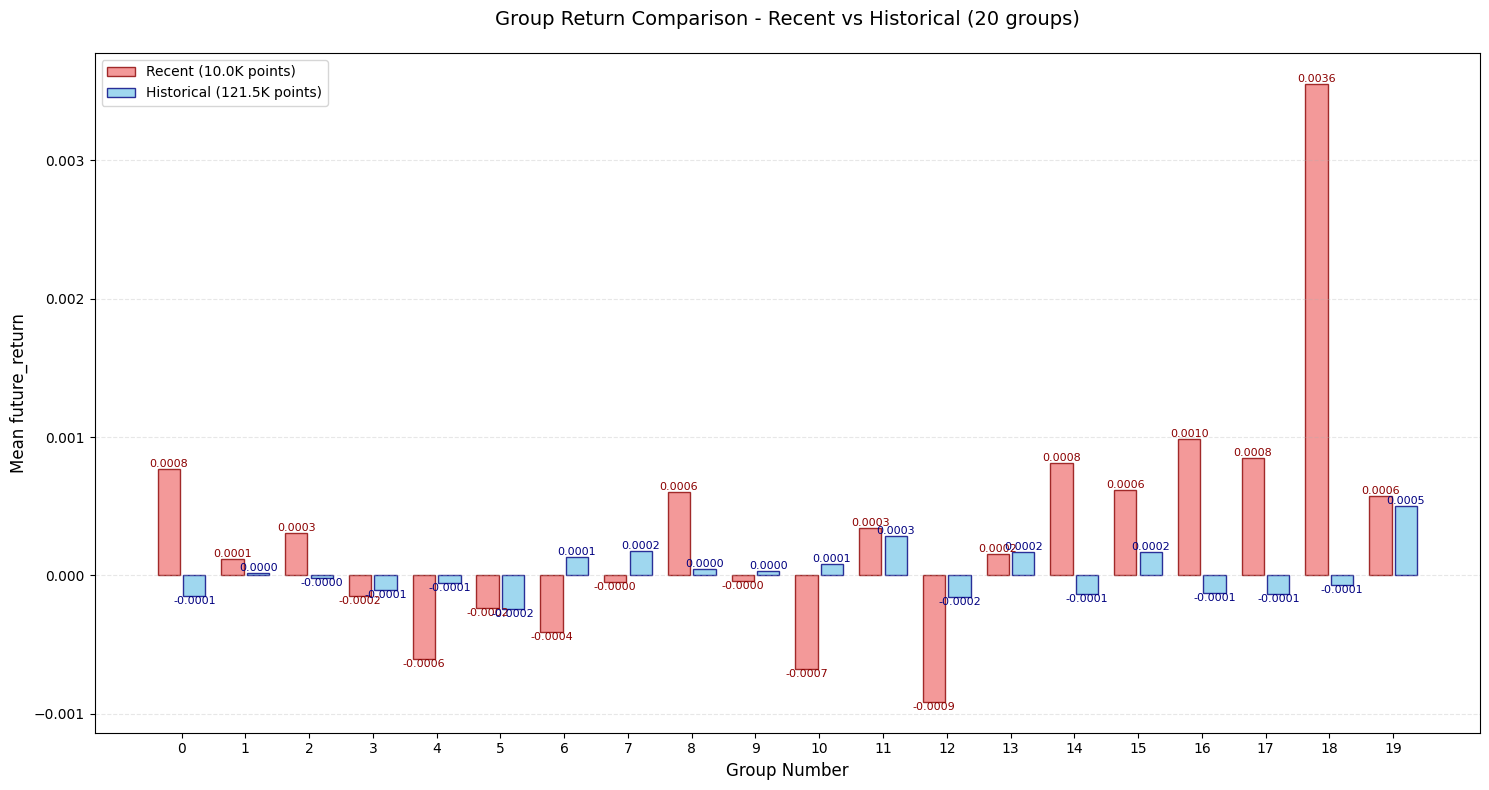

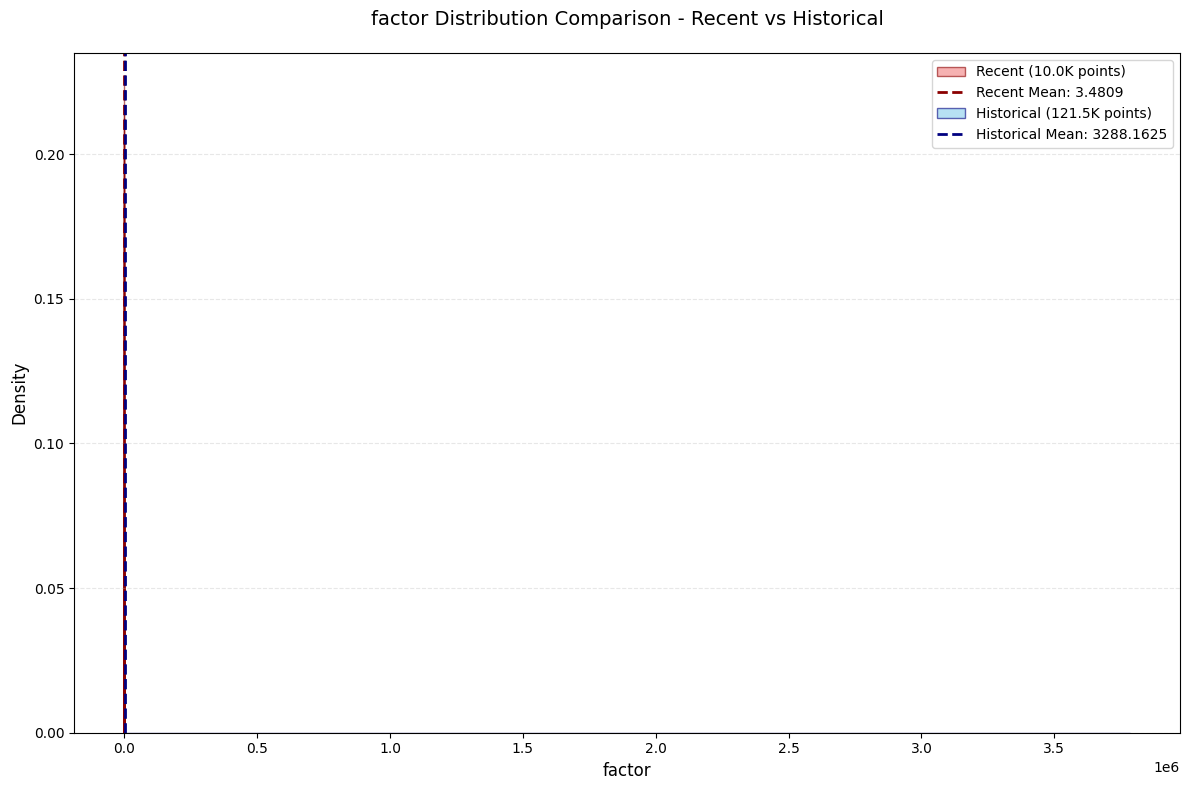

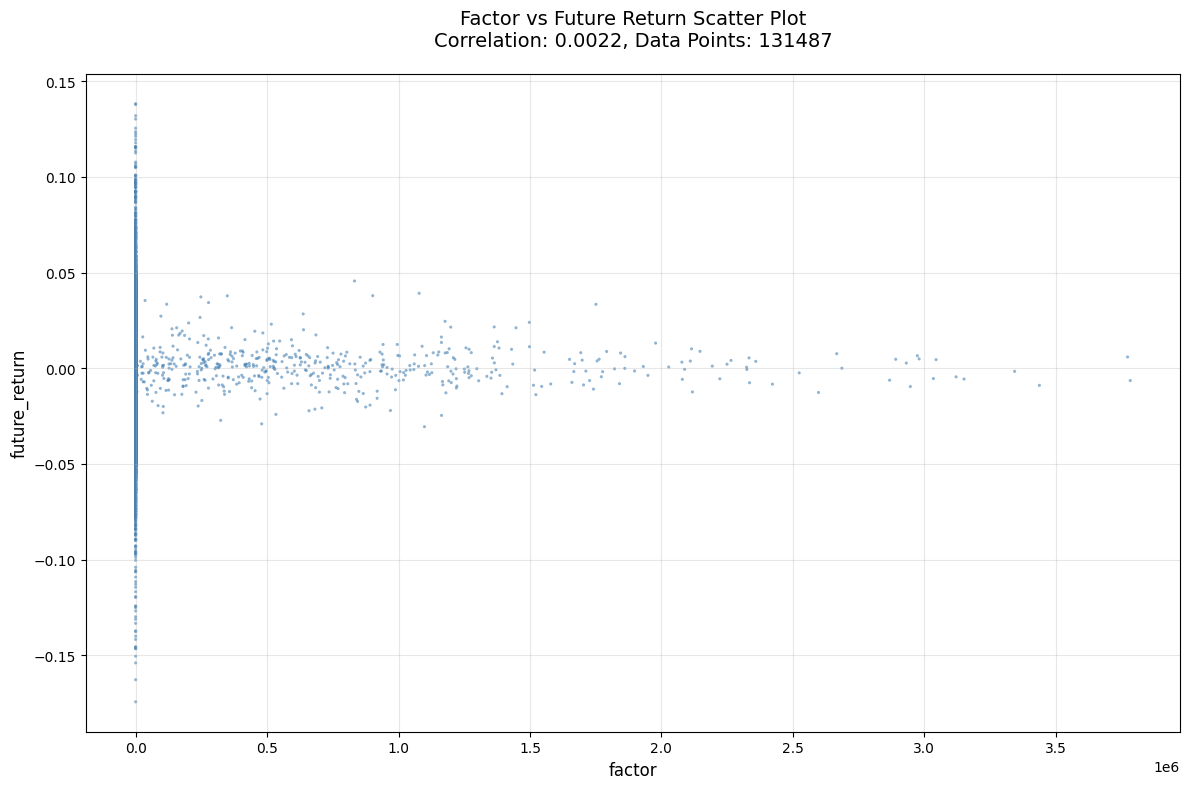

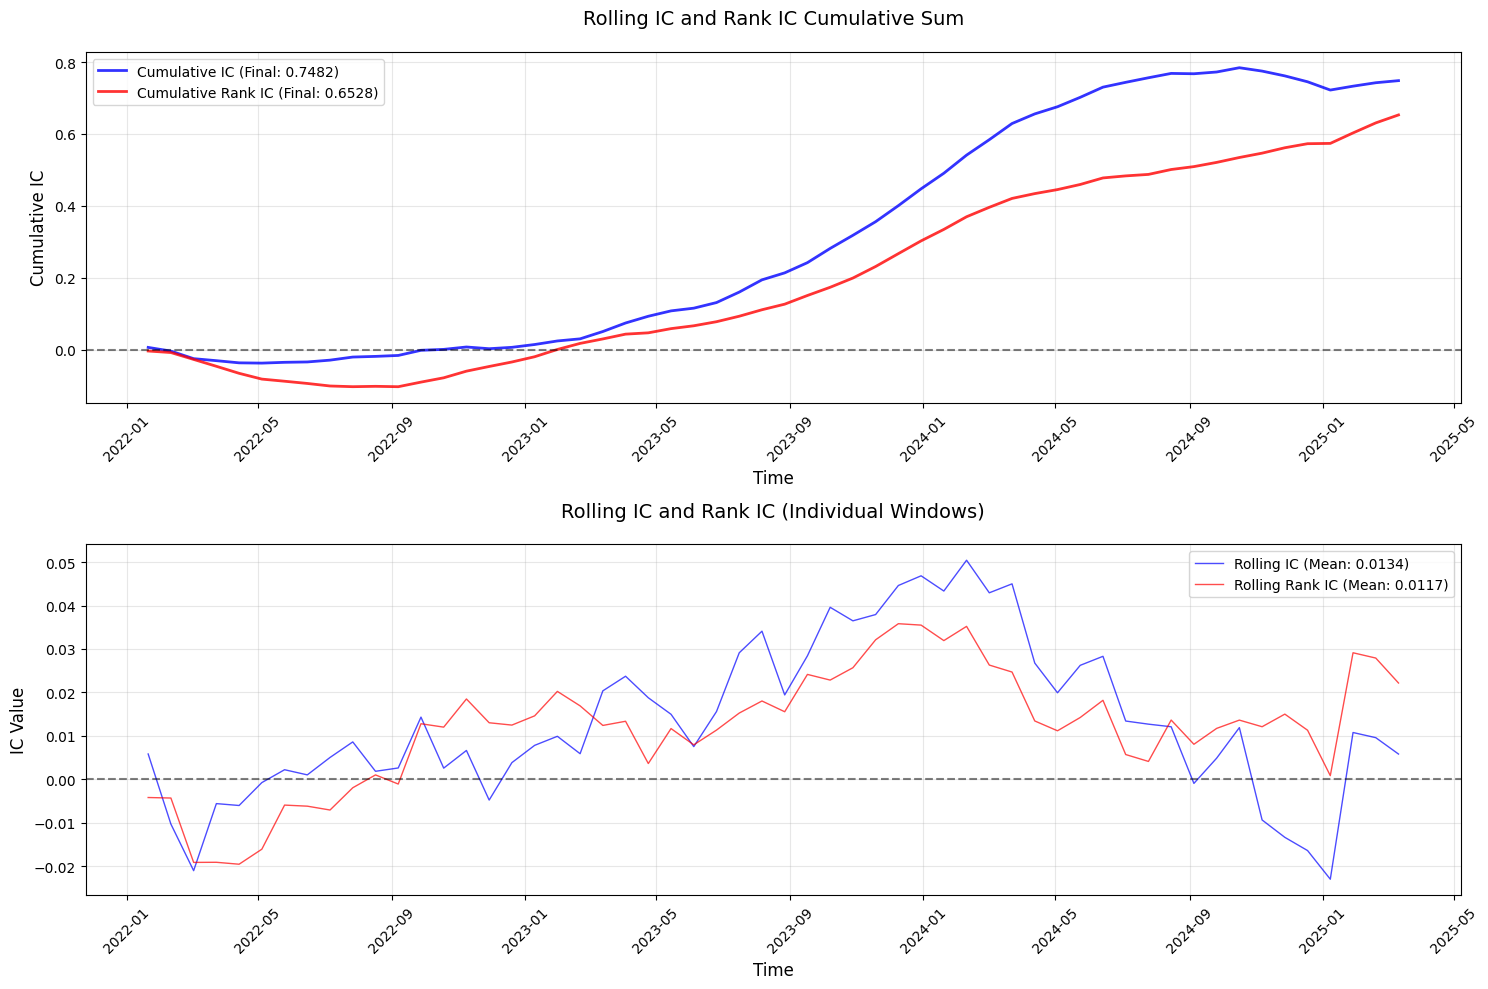

✅ 已显示 4 个图片
----------------------------------------


In [28]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=True)

In [29]:
from tabulate import tabulate

def display_factor_evaluation(result):
    # 1. 基础统计指标
    basic_metrics = [
        ["信息系数(IC)", result['correlation_analysis']['IC']],
        ["秩相关系数(Rank IC)", result['correlation_analysis']['Rank_IC']],
        ["信息比率(IR)", result['information_ratio']['IR']],
        ["分组数量", result['information_ratio']['n_groups']],
        ["数据点数", f"{result['factor_return_scatter']['data_points']:,}"],
        ["异常值(>3σ)", f"{result['factor_distribution']['outlier_analysis']['>3std']*100:.2f}%"],
        ["异常值(>5σ)", f"{result['factor_distribution']['outlier_analysis']['>5std']*100:.2f}%"]
    ]
    
    # 2. 分组分析
    group_stats = result['group_analysis']['group_stats']
    group_table = []
    for idx, row in group_stats.iterrows():
        group_table.append([
            idx,
            f"{row['val_min']:.4f}",
            f"{row['val_max']:.4f}",
            f"{row['val_mean']:.4f}",
            f"{row['return_mean']:.6f}",
            f"{row['return_std']:.4f}",
            row['count']
        ])
    
    # 3. 因子分布描述
    dist_stats = result['factor_distribution']['descriptive_stats']
    distribution_metrics = [
        ["均值", f"{dist_stats['mean']:.4f}"],
        ["标准差", f"{dist_stats['std']:.4f}"],
        ["最小值", f"{dist_stats['min']:.4f}"],
        ["1%分位数", f"{dist_stats['1%']:.4f}"],
        ["5%分位数", f"{dist_stats['5%']:.4f}"],
        ["25%分位数", f"{dist_stats['25%']:.4f}"],
        ["中位数", f"{dist_stats['50%']:.4f}"],
        ["75%分位数", f"{dist_stats['75%']:.4f}"],
        ["95%分位数", f"{dist_stats['95%']:.4f}"],
        ["99%分位数", f"{dist_stats['99%']:.4f}"],
        ["最大值", f"{dist_stats['max']:.4f}"]
    ]
    
    # 4. 分组相关性
    group_correlations = []
    for i, corr in enumerate(result['information_ratio']['group_correlations']):
        group_correlations.append([f"组 {i+1}", f"{corr:.6f}"])
    
    # 5. 滚动IC分析 - 完整展示
    rolling_ic = result['rolling_ic_analysis']['rolling_ic']
    rolling_rank_ic = result['rolling_ic_analysis']['rolling_rank_ic']
    window_centers = result['rolling_ic_analysis']['window_centers']
    cumsum_ic = result['rolling_ic_analysis']['cumsum_ic']
    cumsum_rank_ic = result['rolling_ic_analysis']['cumsum_rank_ic']
    
    # 创建滚动IC数据表格
    rolling_table = []
    for i in range(len(rolling_ic)):
        rolling_table.append([
            window_centers[i].strftime('%Y-%m-%d %H:%M:%S'),
            f"{rolling_ic[i]:.6f}",
            f"{rolling_rank_ic[i]:.6f}",
            f"{cumsum_ic[i]:.6f}",
            f"{cumsum_rank_ic[i]:.6f}"
        ])
    
    # 滚动IC汇总统计
    rolling_metrics = [
        ["滚动IC均值", f"{pd.Series(rolling_ic).mean():.6f}"],
        ["滚动IC标准差", f"{pd.Series(rolling_ic).std():.6f}"],
        ["滚动Rank IC均值", f"{pd.Series(rolling_rank_ic).mean():.6f}"],
        ["滚动Rank IC标准差", f"{pd.Series(rolling_rank_ic).std():.6f}"],
        ["累积IC终值", f"{cumsum_ic[-1]:.6f}"],
        ["累积Rank IC终值", f"{cumsum_rank_ic[-1]:.6f}"],
        ["初始窗口大小", result['rolling_ic_analysis']['initial_window']],
        ["滚动步长", result['rolling_ic_analysis']['rolling_step']]
    ]
    
    # 6. 时间窗口统计
    window_stats = []
    window_data = result['factor_distribution']['window_stats'][10]
    
    # 正确处理时间窗口统计数据
    if isinstance(window_data['stats'], pd.DataFrame):
        # 如果是DataFrame结构
        for idx, row in window_data['stats'].iterrows():
            window_stats.append([
                idx,
                f"{row['mean']:.4f}",
                f"{row['std']:.4f}",
                f"{row['skew']:.4f}",
                f"{row['lambda']:.4f}",
                row['count']
            ])
    else:
        # 如果是字典结构
        for time_range, stats in window_data['stats'].items():
            window_stats.append([
                time_range,
                f"{stats['mean']:.4f}",
                f"{stats['std']:.4f}",
                f"{stats['skew']:.4f}",
                f"{stats['lambda']:.4f}",
                stats['count']
            ])
    
    # # 7. 平稳性测试结果
    # stationarity = result['stationarity_test']
    # stationarity_metrics = [
    #     ["ADF统计量", stationarity['adf_statistic']],
    #     ["P值", stationarity['p_value']],
    #     ["1%临界值", stationarity['critical_values']['1%']],
    #     ["5%临界值", stationarity['critical_values']['5%']],
    #     ["10%临界值", stationarity['critical_values']['10%']],
    #     ["是否平稳", stationarity['is_stationary']],
    #     #["显著性水平", stationarity['alpha']]
    # ]
    
    # 打印所有结果
    print("="*80)
    print("因子评估核心指标".center(80))
    print("="*80)
    print(tabulate(basic_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    # print("\n" + "="*80)
    # print("平稳性测试结果".center(80))
    # print("="*80)
    # print(tabulate(stationarity_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("分组分析结果".center(80))
    print("="*80)
    print(tabulate(group_table, headers=["分组", "最小值", "最大值", "平均值", "收益均值", "收益标准差", "样本数"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("因子分布统计".center(80))
    print("="*80)
    print(tabulate(distribution_metrics, headers=["统计量", "值"], tablefmt="grid", floatfmt=".4f"))
    
    print("\n" + "="*80)
    print("分组相关性".center(80))
    print("="*80)
    print(tabulate(group_correlations, headers=["分组", "相关性"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC分析汇总".center(80))
    print("="*80)
    print(tabulate(rolling_metrics, headers=["指标", "值"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("滚动IC详细数据".center(80))
    print("="*80)
    print(tabulate(rolling_table, headers=["窗口中心", "滚动IC", "滚动Rank IC", "累积IC", "累积Rank IC"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("时间窗口统计".center(80))
    print("="*80)
    print(tabulate(window_stats, headers=["时间窗口", "均值", "标准差", "偏度", "Lambda", "样本数"], tablefmt="grid"))
    print(f"时间范围: {window_data['time_ranges']}")

# 调用展示函数
display_factor_evaluation(result)

                                    因子评估核心指标                                    
+---------------------+----------------------+
| 指标                | 值                   |
+=====================+======================+
| 信息系数(IC)        | 0.002223412823437539 |
+---------------------+----------------------+
| 秩相关系数(Rank IC) | 0.01114014139731072  |
+---------------------+----------------------+
| 信息比率(IR)        | 0.3005120161271599   |
+---------------------+----------------------+
| 分组数量            | 10                   |
+---------------------+----------------------+
| 数据点数            | 131,487              |
+---------------------+----------------------+
| 异常值(>3σ)         | 0.32%                |
+---------------------+----------------------+
| 异常值(>5σ)         | 0.27%                |
+---------------------+----------------------+

                                     分组分析结果                                     
+--------+----------+-------------+------------+------------+-------